# Posterior inference using numpyro

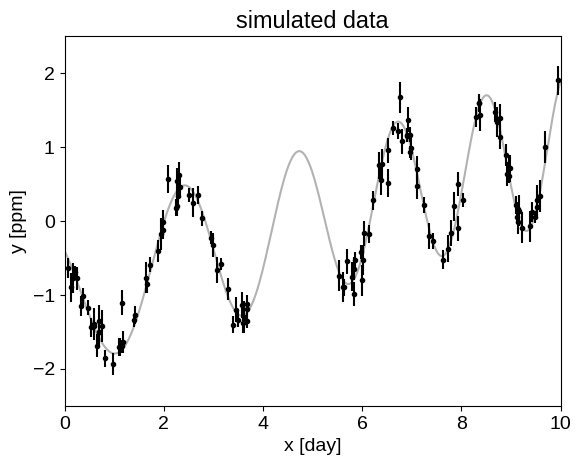

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

t = np.sort(
    np.append(
        np.random.uniform(0, 3.8, 57),
        np.random.uniform(5.5, 10, 68),
    )
)  # The input coordinates must be sorted
yerr = np.random.uniform(0.08, 0.22, len(t))
y = (
    0.2 * (t - 5)
    + np.sin(3 * t + 0.1 * (t - 5) ** 2)
    + yerr * np.random.randn(len(t))
)

true_t = np.linspace(0, 10, 500)
true_y = 0.2 * (true_t - 5) + np.sin(3 * true_t + 0.1 * (true_t - 5) ** 2)

plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("x [day]")
plt.ylabel("y [ppm]")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5)
_ = plt.title("simulated data")

In [2]:
import numpyro
numpyro.set_host_device_count(2)

from jax.config import config
config.update("jax_enable_x64", True)

from jax import random
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

from tinygp import kernels, GaussianProcess


prior_sigma = 5.0

def numpyro_model(t, yerr, y=None):
    mean = numpyro.sample("mean", dist.Normal(0.0, prior_sigma))
    jitter = numpyro.sample("jitter", dist.HalfNormal(prior_sigma))

    sigma1 = numpyro.sample("sigma1", dist.HalfNormal(prior_sigma))
    rho1 = numpyro.sample("rho1", dist.HalfNormal(prior_sigma))
    tau = numpyro.sample("tau", dist.HalfNormal(prior_sigma))
    kernel1 = sigma1 ** 2 * kernels.ExpSquared(tau) * kernels.Cosine(rho1)

    sigma2 = numpyro.sample("sigma2", dist.HalfNormal(prior_sigma))
    rho2 = numpyro.sample("rho2", dist.HalfNormal(prior_sigma))
    kernel2 = sigma2 ** 2 * kernels.Matern32(rho2)

    kernel = kernel1 + kernel2
    gp = GaussianProcess(kernel, t, diag=yerr ** 2 + jitter, mean=mean)

    numpyro.sample("obs", gp.to_numpyro(), obs=y)

    if y is not None:
        gp.condition(y)
        numpyro.deterministic("pred", gp.predict(true_t))


nuts_kernel = NUTS(numpyro_model, dense_mass=True, target_accept_prob=0.9)
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=1000, num_chains=2)
rng_key = random.PRNGKey(34923)

In [3]:
%%time
mcmc.run(rng_key, t, yerr, y=y)
samples = mcmc.get_samples()
pred = samples["pred"].block_until_ready()  # Blocking to get timing right

CPU times: user 8min 58s, sys: 3min 12s, total: 12min 10s
Wall time: 6min 16s


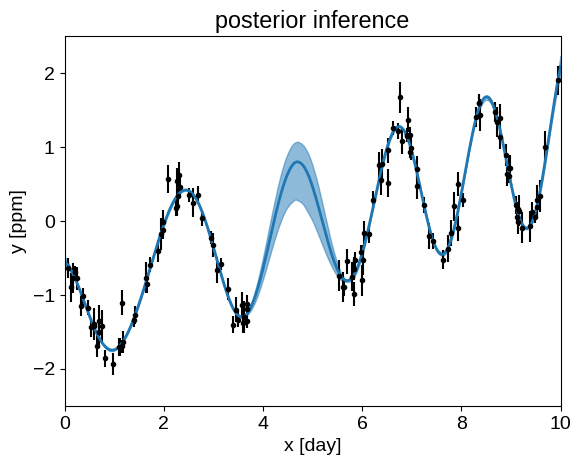

In [4]:
q = np.percentile(pred, [5, 50, 95], axis=0)
plt.fill_between(true_t, q[0], q[2], color="C0", alpha=0.5)
plt.plot(true_t, q[1], color="C0", lw=2)

plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("x [day]")
plt.ylabel("y [ppm]")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5)
_ = plt.title("posterior inference")

In [5]:
import arviz as az
data = az.from_numpyro(mcmc)
az.summary(data, var_names=[v for v in data.posterior.data_vars if v != "pred"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
jitter,0.003,0.002,0.000,0.007,0.000,0.000,2089.0,2089.0,1263.0,707.0,1.0
mean,0.078,1.579,-2.790,3.420,0.051,0.043,964.0,665.0,1046.0,711.0,1.0
rho1,2.183,0.578,1.797,2.616,0.048,0.034,148.0,148.0,410.0,186.0,1.0
rho2,7.733,3.063,2.414,13.400,0.080,0.056,1475.0,1475.0,1335.0,1168.0,1.0
sigma1,0.964,0.387,0.427,1.627,0.013,0.010,926.0,831.0,1357.0,831.0,1.0
sigma2,1.925,1.051,0.510,3.902,0.033,0.023,1007.0,1007.0,1026.0,1390.0,1.0
tau,2.292,0.790,0.727,3.602,0.033,0.023,573.0,573.0,452.0,206.0,1.0
